# <a id='fifth'></a> Feature Engineering

### Dynamic Pricing Calculation

This section of code calculates the dynamic pricing adjustments for rides based on demand and supply factors. Here's a breakdown of the process:

1. **Demand Multiplier Calculation**:
   - `high_demand_percentile` and `low_demand_percentile` are defined to set the percentiles for high and low demand, respectively.
   - The `demand_multiplier` is calculated based on the percentile for high and low demand. For each ride, it compares the number of riders (`Number_of_Riders`) with the respective percentiles. If the number of riders is above the high demand percentile, it divides the number of riders by the high demand percentile value. If it's below the low demand percentile, it divides by the low demand percentile value.

2. **Supply Multiplier Calculation**:
   - Similar to demand, `high_supply_percentile` and `low_supply_percentile` are defined for setting the percentiles for high and low supply, respectively.
   - The `supply_multiplier` is calculated based on the percentile for high and low supply. For each ride, it compares the number of drivers (`Number_of_Drivers`) with the respective percentiles. If the number of drivers is above the low supply percentile, it divides the high supply percentile value by the number of drivers. If it's below the low supply percentile, it divides the low supply percentile value by the number of drivers.

3. **Price Adjustment Factors**:
   - `demand_threshold_high`, `demand_threshold_low`, `supply_threshold_high`, and `supply_threshold_low` are defined to set the thresholds for high and low demand/supply.

4. **Adjusted Ride Cost Calculation**:
   - The `adjusted_ride_cost` is calculated based on the historical cost of the ride (`Historical_Cost_of_Ride`) and the dynamic pricing adjustments determined by the demand and supply multipliers. It takes the maximum of demand multiplier and demand threshold low, and the maximum of supply multiplier and supply threshold high, then multiplies these values with the historical cost of the ride.

Overall, this process adjusts the ride cost dynamically based on demand and supply conditions to optimize pricing and maximize revenue.

# <a id='first'></a> Importing Libraries & Loading Data

In [31]:
# Ignore Warnings
import warnings

# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Transformation
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [32]:
# Path to the CSV data file
ORIGINAL_DATASET_PATH = "../data/dynamic_pricing_raw.csv" 

# Reading data from the CSV file into a DataFrame using the first column as the index
df = pd.read_csv(ORIGINAL_DATASET_PATH)

# Displaying the first few rows of the DataFrame
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [33]:
# Calculate demand_multiplier based on percentile for high and low demand
high_demand_percentile = 75
low_demand_percentile = 25

df['demand_multiplier'] = np.where(df['Number_of_Riders'] > np.percentile(df['Number_of_Riders'], high_demand_percentile),
                                   df['Number_of_Riders'] / np.percentile(df['Number_of_Riders'], high_demand_percentile),
                                   df['Number_of_Riders'] / np.percentile(df['Number_of_Riders'], low_demand_percentile))

# Calculate supply_multiplier based on percentile for high and low supply
high_supply_percentile = 75
low_supply_percentile = 25

df['supply_multiplier'] = np.where(df['Number_of_Drivers'] > np.percentile(df['Number_of_Drivers'], low_supply_percentile),
                                   np.percentile(df['Number_of_Drivers'], high_supply_percentile) / df['Number_of_Drivers'], 
                                   np.percentile(df['Number_of_Drivers'], low_supply_percentile) / df['Number_of_Drivers'])

# Define price adjustment factors for high and low demand/supply
demand_threshold_high = 1.2  # Higher demand threshold
demand_threshold_low = 0.8  # Lower demand threshold
supply_threshold_high = 0.8  # Higher supply threshold
supply_threshold_low = 1.2  # Lower supply threshold

# Calculate adjusted_ride_cost for dynamic pricing
df['adjusted_ride_cost'] = df['Historical_Cost_of_Ride'] * (
    np.maximum(df['demand_multiplier'], demand_threshold_low) *
    np.maximum(df['supply_multiplier'], supply_threshold_high)
)

In [34]:
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,demand_multiplier,supply_multiplier,adjusted_ride_cost
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273,1.111111,0.844444,266.710528
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753,1.450000,0.974359,245.653817
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469,1.050000,1.225806,424.478684
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232,1.098765,1.357143,701.155452
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422,1.950000,1.727273,1952.472427


### Profitability Analysis of Rides

This section of code analyzes the profitability of rides by comparing the adjusted ride cost (calculated using dynamic pricing) with the historical cost of the ride. Here's a breakdown of the process:

1. **Profit Percentage Calculation**:
   - The profit percentage for each ride is calculated using the formula:
   
     $
     \text{Profit Percentage} = \left( \frac{{\text{Adjusted Ride Cost} - \text{Historical Cost of Ride}}}{{\text{Historical Cost of Ride}}} \right) \times 100
     $
   - This formula computes the percentage increase or decrease in the cost of the ride after applying dynamic pricing compared to its historical cost.

2. **Identification of Profitable and Loss Rides**:
   - Profitable rides are identified where the profit percentage is positive.
   - Loss rides are identified where the profit percentage is negative.

3. **Counting of Profitable and Loss Rides**:
   - The count of profitable and loss rides is calculated.

4. **Visualization using Donut Chart**:
   - A donut chart is created to visualize the distribution of profitable and loss rides.
   - Labels and values are defined for 'Profitable Rides' and 'Loss Rides'.

Overall, this analysis provides insights into the impact of dynamic pricing on the profitability of rides, helping to understand the effectiveness of the pricing strategy in maximizing revenue.

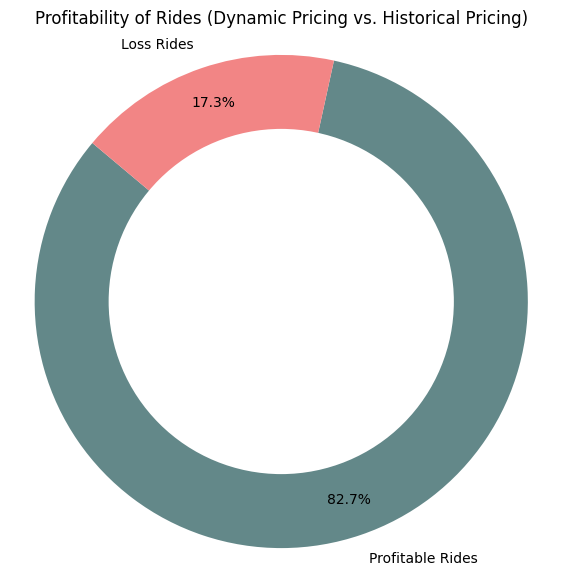

In [35]:
# Calculate the profit percentage for each ride
df['profit_percentage'] = ((df['adjusted_ride_cost'] - df['Historical_Cost_of_Ride']) / df['Historical_Cost_of_Ride']) * 100
# Identify profitable rides where profit percentage is positive
profitable_rides = df[df['profit_percentage'] > 0]

# Identify loss rides where profit percentage is negative
loss_rides = df[df['profit_percentage'] < 0]

# Calculate the count of profitable and loss rides
profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

# Create a donut chart to show the distribution of profitable and loss rides
labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_count, loss_count]

plt.figure(figsize=(7, 7))

# Create a pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, 
        colors = ['#638889', '#f28585'], labeldistance = 1.1,
                  pctdistance = 0.85, normalize=True
)

# Draw a circle in the center to create a ring
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.title('Profitability of Rides (Dynamic Pricing vs. Historical Pricing)')


plt.show()

### Log Transformation of Target Variable

In this code snippet, the target variable `adjusted_ride_cost` is transformed using the natural logarithm plus one transformation (`np.log1p`). This transformation is commonly used to deal with skewed distributions and heteroscedasticity in regression analysis.

#### Log Transformation:
- The `np.log1p` function applies the natural logarithm transformation plus one to each value of the target variable `adjusted_ride_cost`.
- Adding one before taking the logarithm helps avoid errors when the original value is zero.

#### Benefits of Log Transformation:
- **Normalization**: Log transformation can help normalize the distribution of the target variable, making it more symmetric.
- **Homoscedasticity**: It can stabilize the variance of the target variable, making it more homoscedastic.
- **Linear Relationships**: Log-transformed variables often result in more linear relationships with predictor variables in regression models.

#### Considerations:
- Log transformation is suitable for variables with right-skewed or positively skewed distributions.
- However, it may not be appropriate for variables with zero or negative values.

In [36]:
# Calculate the skewness of the target variable 'TARGET' and round the result to 2 decimal places
print("Skewness: ", round(df['adjusted_ride_cost'].skew(), 2))

Skewness:  1.58


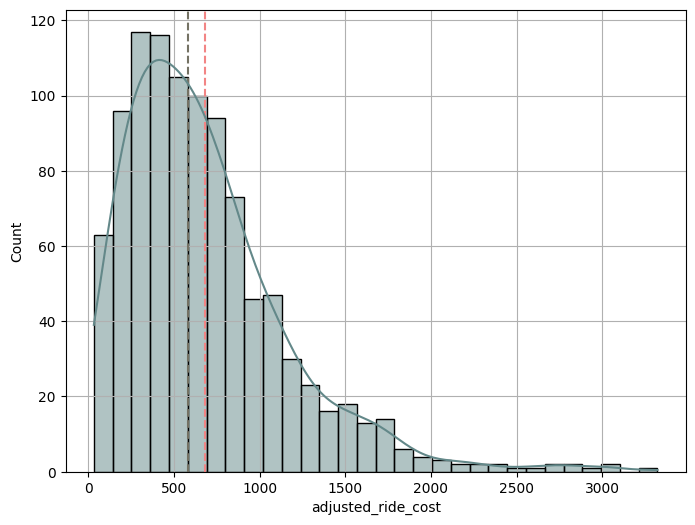

In [37]:
# Create a new figure with a specified size (8 inches width, 6 inches height)
plt.figure(figsize=(8, 6))

# Calculate the mean and median of the 'adjusted_ride_cost' column
mean_values = df['adjusted_ride_cost'].mean()
median = df['adjusted_ride_cost'].median()

# Add vertical lines for mean and median to the plot
plt.axvline(x=mean_values, color='#F28585', linestyle='--', label='Mean')
plt.axvline(x=median, color='#747264', linestyle='--', label='Median')

# Create a histogram plot with KDE (Kernel Density Estimation)
sns.histplot(df['adjusted_ride_cost'], kde=True, color='#638889')

# Add grid lines to the plot
plt.grid(True)

# Display the plot
plt.show()

In [38]:
# Apply the natural logarithm transformation plus 1 to the target variable 'TARGET'
df['adjusted_ride_cost'] = np.log1p(df['adjusted_ride_cost'])

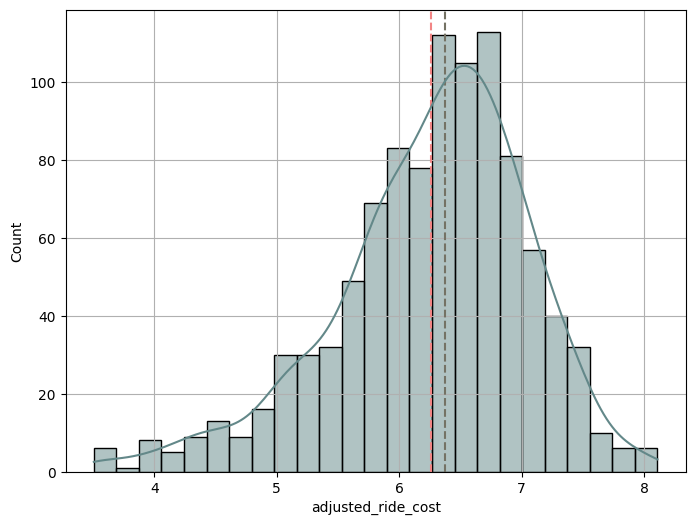

In [39]:
# Create a new figure with a specified size (8 inches width, 6 inches height)
plt.figure(figsize=(8, 6))

# Calculate the mean and median of the 'adjusted_ride_cost' column
mean_value = df['adjusted_ride_cost'].mean()
median = df['adjusted_ride_cost'].median()

# Plot vertical lines indicating mean and median on the histogram plot
plt.axvline(x=mean_value, color='#F28585', linestyle='--', label='Mean')
plt.axvline(x=median, color='#747264', linestyle='--', label='Median')

# Create a histogram plot with KDE (Kernel Density Estimation)
sns.histplot(df['adjusted_ride_cost'], kde=True, color='#638889')

# Add grid lines to the plot
plt.grid(True)

# Display the plot
plt.show()

In [40]:
# Calculate the skewness of the transformed target variable 'TARGET' and round the result to 2 decimal places
print("Skewness: ", round(df['adjusted_ride_cost'].skew(), 2))

Skewness:  -0.72



### Box-Cox Transformation for Skewed Features

In this code snippet, a Box-Cox transformation is applied to skewed features in the dataset to reduce skewness and make the distribution more symmetric. Box-Cox transformation is a power transformation technique that is particularly effective for dealing with skewed data.

#### Steps:
1. **Estimating Lambda Parameter**: The lambda parameter for the Box-Cox transformation is estimated using `boxcox_normmax` function. Adding 2 to each value helps avoid non-positive values, which are not supported by the transformation.
2. **Applying Box-Cox Transformation**: The Box-Cox transformation is applied to the feature using the estimated lambda parameter, `lambda_est`.


#### Benefits of Box-Cox Transformation:
- **Skewness Reduction**: Box-Cox transformation helps reduce skewness in the distribution of the features.
- **Normalization**: It can make the distribution more symmetric, which is beneficial for many statistical analyses and machine learning algorithms.

#### Considerations:
- Box-Cox transformation assumes that the data is continuous and positive.
- It may not be suitable for features with zero or negative values.
- Care should be taken when estimating the lambda parameter, as incorrect estimation can lead to improper transformation.

In [41]:
# Print the skewness of the transformed 'Number_of_Drivers' column
print("Skewness: ", round(df['Number_of_Drivers'].skew(), 2))

Skewness:  0.96


In [42]:
# Estimate the optimal Box-Cox transformation parameter lambda for 'Number_of_Drivers' column
lambda_est = boxcox_normmax(df['Number_of_Drivers'] + 2, brack=(-1.5, 1.5))

# Apply the Box-Cox transformation to the 'Number_of_Drivers' column using the estimated lambda
df['Number_of_Drivers'] = boxcox1p(df['Number_of_Drivers'], lambda_est)

# Print the skewness of the transformed 'Number_of_Drivers' column
print("Skewness: ", round(df['Number_of_Drivers'].skew(), 2))

Skewness:  -0.01


# <a id='sixth'></a> Save the processed dataset

In [43]:
df.to_csv("../data/dynamic_pricing_processed.csv", index=False)